# 04 — Model 2: Collaborative Filtering (Matrix Factorization)
## Fitness Workout Recommender

This model learns latent factors from the user-exercise interaction matrix using SVD.
Unlike content-based, it discovers patterns from behavior — not just attributes.

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
np.random.seed(42)
print('Libraries loaded!')

Libraries loaded!


In [2]:
exercises = pd.read_csv('../data/processed/exercises_clean.csv')
users = pd.read_csv('../data/processed/user_profiles.csv')
interactions = pd.read_csv('../data/processed/user_exercise_interactions.csv')

print(f'Exercises: {len(exercises)}')
print(f'Users: {len(users)}')
print(f'Interactions: {len(interactions)}')

Exercises: 52
Users: 1000
Interactions: 15000


## 1. Build User-Exercise Interaction Matrix

Create a matrix where rows = users, columns = exercises, values = ratings.
Missing entries are filled with 0 (implicit: user hasn't tried it).

In [3]:
# Create train/test split (same as notebook 03 for fair comparison)
train_interactions = []
test_interactions = []

for user_id in interactions['user_id'].unique():
    user_ints = interactions[interactions['user_id'] == user_id]
    if len(user_ints) >= 4:
        train, test = train_test_split(user_ints, test_size=0.2, random_state=42)
        train_interactions.append(train)
        test_interactions.append(test)
    else:
        train_interactions.append(user_ints)

train_df = pd.concat(train_interactions).reset_index(drop=True)
test_df = pd.concat(test_interactions).reset_index(drop=True)

print(f'Train: {len(train_df)}, Test: {len(test_df)}')

# Ground truth
ground_truth = {}
for user_id in test_df['user_id'].unique():
    user_test = test_df[test_df['user_id'] == user_id]
    liked = set(user_test[user_test['rating'] >= 3.0]['exercise_id'].values)
    if liked:
        ground_truth[user_id] = liked

print(f'Users with test ground truth: {len(ground_truth)}')

Train: 12000, Test: 3000
Users with test ground truth: 919


In [4]:
# Build the interaction matrix from TRAINING data only
user_ids = sorted(users['user_id'].unique())
exercise_ids = sorted(exercises['exercise_id'].unique())

user_to_idx = {uid: i for i, uid in enumerate(user_ids)}
exercise_to_idx = {eid: i for i, eid in enumerate(exercise_ids)}
idx_to_exercise = {i: eid for eid, i in exercise_to_idx.items()}

# Create matrix (users x exercises)
R = np.zeros((len(user_ids), len(exercise_ids)))

for _, row in train_df.iterrows():
    u = user_to_idx[row['user_id']]
    e = exercise_to_idx[row['exercise_id']]
    R[u, e] = row['rating']

print(f'Interaction matrix shape: {R.shape}')
print(f'Non-zero entries: {np.count_nonzero(R)} ({np.count_nonzero(R) / R.size * 100:.1f}%)')
print(f'Sparsity: {1 - np.count_nonzero(R) / R.size:.4f}')

Interaction matrix shape: (1000, 52)
Non-zero entries: 12000 (23.1%)
Sparsity: 0.7692


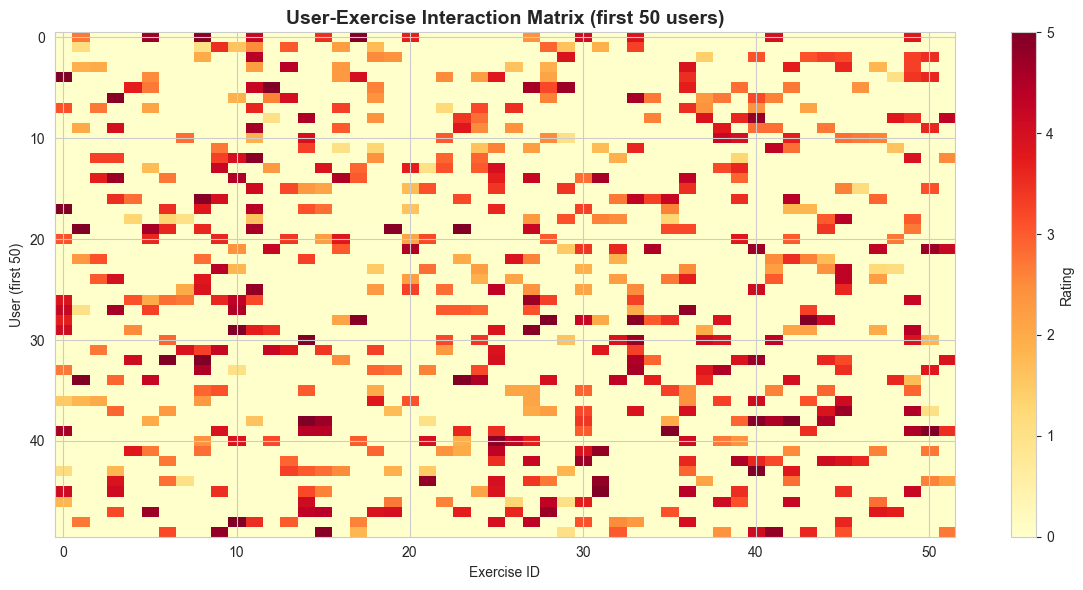

In [5]:
# Visualize the interaction matrix (sample)
plt.figure(figsize=(12, 6))
plt.imshow(R[:50, :], aspect='auto', cmap='YlOrRd', interpolation='nearest')
plt.colorbar(label='Rating')
plt.xlabel('Exercise ID')
plt.ylabel('User (first 50)')
plt.title('User-Exercise Interaction Matrix (first 50 users)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/figures/07_interaction_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. Matrix Factorization with SVD

We decompose the interaction matrix R into:
- **R ≈ U × Σ × V^T**

Where:
- U = user latent factors (what users implicitly prefer)
- V = exercise latent factors (hidden exercise characteristics)
- Σ = singular values (importance of each factor)

We use `TruncatedSVD` from scikit-learn, which handles sparse matrices efficiently.

In [6]:
# Mean-center the ratings (important for SVD quality)
user_means = np.zeros(R.shape[0])
R_centered = R.copy()

for i in range(R.shape[0]):
    rated_mask = R[i] > 0
    if rated_mask.sum() > 0:
        user_means[i] = R[i, rated_mask].mean()
        R_centered[i, rated_mask] -= user_means[i]

print(f'Mean-centered matrix. Average user mean: {user_means.mean():.2f}')

Mean-centered matrix. Average user mean: 3.27


n_factors=  5 | Explained variance: 0.2399
n_factors= 10 | Explained variance: 0.3774
n_factors= 15 | Explained variance: 0.4952
n_factors= 20 | Explained variance: 0.5971
n_factors= 30 | Explained variance: 0.7678


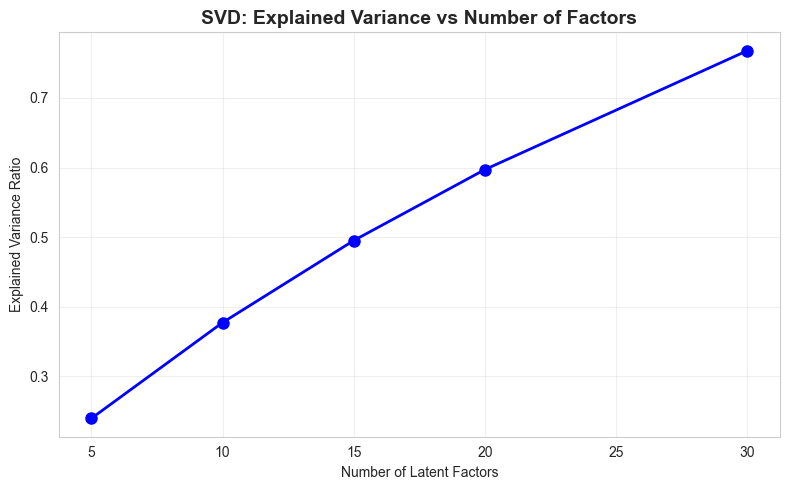

In [7]:
# Try different numbers of latent factors
n_factors_list = [5, 10, 15, 20, 30]
explained_variances = []

for n in n_factors_list:
    svd = TruncatedSVD(n_components=n, random_state=42)
    svd.fit(R_centered)
    explained_variances.append(svd.explained_variance_ratio_.sum())
    print(f'n_factors={n:3d} | Explained variance: {svd.explained_variance_ratio_.sum():.4f}')

plt.figure(figsize=(8, 5))
plt.plot(n_factors_list, explained_variances, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Latent Factors')
plt.ylabel('Explained Variance Ratio')
plt.title('SVD: Explained Variance vs Number of Factors', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/figures/08_svd_variance.png', dpi=150, bbox_inches='tight')
plt.show()

In [8]:
# Choose optimal n_factors (elbow method — pick where gains flatten)
N_FACTORS = 15  # Adjust based on the plot above

svd = TruncatedSVD(n_components=N_FACTORS, random_state=42)
user_factors = svd.fit_transform(R_centered)  # U * Sigma
exercise_factors = svd.components_.T             # V

print(f'User factors: {user_factors.shape}')
print(f'Exercise factors: {exercise_factors.shape}')
print(f'Explained variance: {svd.explained_variance_ratio_.sum():.4f}')

User factors: (1000, 15)
Exercise factors: (52, 15)
Explained variance: 0.4952


In [9]:
# Reconstruct the full predicted ratings matrix
R_pred = user_factors @ svd.components_ 

# Add back user means
for i in range(R_pred.shape[0]):
    R_pred[i] += user_means[i]

print(f'Predicted ratings matrix: {R_pred.shape}')
print(f'Rating range: {R_pred.min():.2f} to {R_pred.max():.2f}')

Predicted ratings matrix: (1000, 52)
Rating range: 0.72 to 5.37


## 3. Visualize Latent Factors

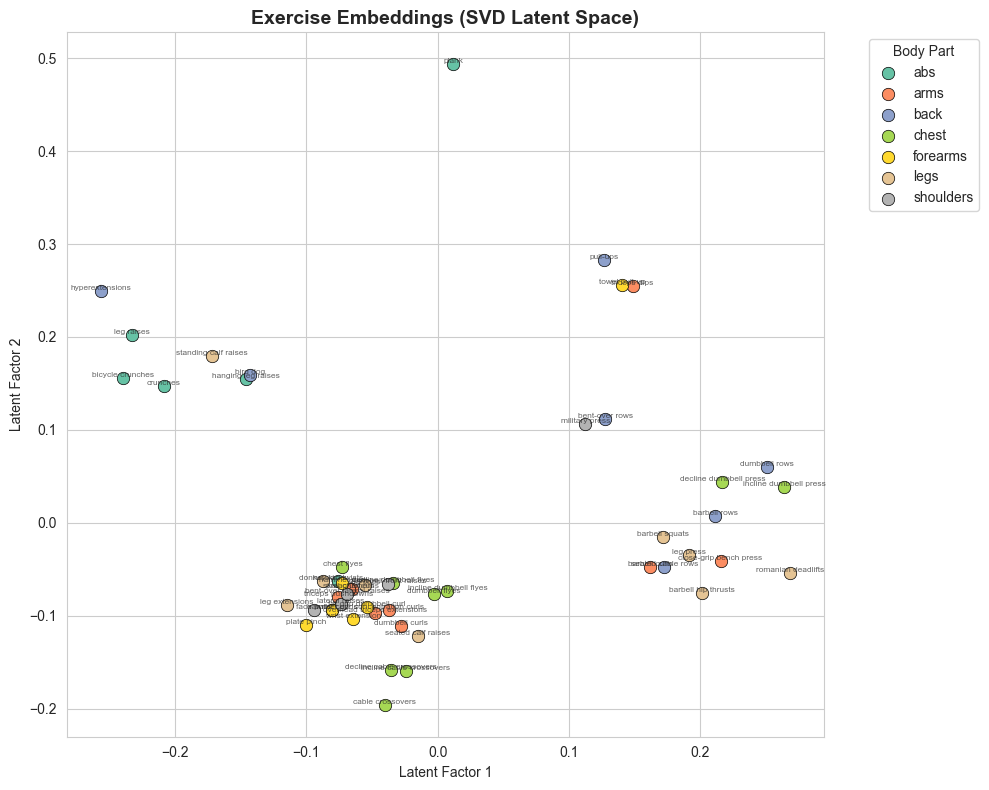

Exercises that cluster together are perceived similarly by users!


In [10]:
# Visualize exercise embeddings in 2D (first 2 factors)
fig, ax = plt.subplots(figsize=(10, 8))

body_parts = exercises['body_part'].values
unique_bp = sorted(exercises['body_part'].unique())
colors = plt.cm.Set2(np.linspace(0, 1, len(unique_bp)))
bp_to_color = {bp: colors[i] for i, bp in enumerate(unique_bp)}

for bp in unique_bp:
    mask = body_parts == bp
    ax.scatter(exercise_factors[mask, 0], exercise_factors[mask, 1],
              c=[bp_to_color[bp]], label=bp, s=80, edgecolors='black', linewidth=0.5)

# Add exercise name labels
for i, name in enumerate(exercises['exercise_name'].values):
    ax.annotate(name, (exercise_factors[i, 0], exercise_factors[i, 1]),
               fontsize=6, alpha=0.7, ha='center', va='bottom')

ax.set_xlabel('Latent Factor 1')
ax.set_ylabel('Latent Factor 2')
ax.set_title('Exercise Embeddings (SVD Latent Space)', fontsize=14, fontweight='bold')
ax.legend(title='Body Part', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('../results/figures/09_exercise_embeddings.png', dpi=150, bbox_inches='tight')
plt.show()
print('Exercises that cluster together are perceived similarly by users!')

## 4. Generate Recommendations & Evaluate

In [11]:
def recommend_svd(user_id, R_pred, train_df, user_to_idx, idx_to_exercise, top_k=10):
    """
    Recommend top-K exercises based on predicted ratings from SVD.
    Excludes exercises the user already interacted with in training.
    """
    u_idx = user_to_idx[user_id]
    pred_ratings = R_pred[u_idx]
    
    # Get training exercise IDs for this user
    train_eids = set(train_df[train_df['user_id'] == user_id]['exercise_id'].values)
    
    # Rank all exercises, excluding training ones
    candidates = []
    for e_idx in range(len(pred_ratings)):
        eid = idx_to_exercise[e_idx]
        if eid not in train_eids:
            candidates.append((eid, pred_ratings[e_idx]))
    
    candidates.sort(key=lambda x: x[1], reverse=True)
    return [eid for eid, _ in candidates[:top_k]]

# Test recommendation for user 0
test_recs = recommend_svd('user_0000', R_pred, train_df, user_to_idx, idx_to_exercise, top_k=10)
print(f'User 0 top 10 recommendations:')
for eid in test_recs:
    ex = exercises[exercises['exercise_id'] == eid].iloc[0]
    print(f'  {ex["exercise_name"]:40s} | {ex["body_part"]:12s} | {ex["equipment"]:12s}')

User 0 top 10 recommendations:
  incline dumbbell flyes                   | chest        | dumbbells   
  fat grip dumbbell curl                   | forearms     | dumbbells   
  barbell hip thrusts                      | legs         | barbell     
  incline dumbbell press                   | chest        | dumbbells   
  dumbbell front raises                    | shoulders    | dumbbells   
  hyperextensions                          | back         | bodyweight  
  decline dumbbell press                   | chest        | dumbbells   
  wrist curl                               | forearms     | other       
  plank                                    | abs          | bodyweight  
  face pulls                               | shoulders    | other       


In [12]:
# --- Evaluation Metrics (same as notebook 03) ---

def precision_at_k(recommended, relevant, k):
    return len(set(recommended[:k]) & relevant) / k

def recall_at_k(recommended, relevant, k):
    if not relevant: return 0.0
    return len(set(recommended[:k]) & relevant) / len(relevant)

def ndcg_at_k(recommended, relevant, k):
    dcg = sum(1.0/np.log2(i+2) for i, item in enumerate(recommended[:k]) if item in relevant)
    idcg = sum(1.0/np.log2(i+2) for i in range(min(len(relevant), k)))
    return dcg/idcg if idcg > 0 else 0.0

def hit_rate_at_k(recommended, relevant, k):
    return 1.0 if set(recommended[:k]) & relevant else 0.0

# Evaluate
K_VALUES = [5, 10]
results = {k: {'precision': [], 'recall': [], 'ndcg': [], 'hit_rate': []} for k in K_VALUES}

for user_id, relevant in ground_truth.items():
    rec_ids = recommend_svd(user_id, R_pred, train_df, user_to_idx, idx_to_exercise, top_k=20)
    
    for k in K_VALUES:
        results[k]['precision'].append(precision_at_k(rec_ids, relevant, k))
        results[k]['recall'].append(recall_at_k(rec_ids, relevant, k))
        results[k]['ndcg'].append(ndcg_at_k(rec_ids, relevant, k))
        results[k]['hit_rate'].append(hit_rate_at_k(rec_ids, relevant, k))

print('=== Collaborative Filtering (SVD) Results ===')
print(f'{"Metric":<20} {"@5":>10} {"@10":>10}')
print('-' * 42)
for metric in ['precision', 'recall', 'ndcg', 'hit_rate']:
    vals = [np.mean(results[k][metric]) for k in K_VALUES]
    print(f'{metric:<20} {vals[0]:>10.4f} {vals[1]:>10.4f}')

=== Collaborative Filtering (SVD) Results ===
Metric                       @5        @10
------------------------------------------
precision                0.0810     0.0741
recall                   0.2067     0.3818
ndcg                     0.1511     0.2184
hit_rate                 0.3591     0.5963


In [13]:
# Save results
cf_results = {}
for k in K_VALUES:
    for metric in ['precision', 'recall', 'ndcg', 'hit_rate']:
        cf_results[f'{metric}@{k}'] = float(np.mean(results[k][metric]))

with open('../results/metrics/collaborative_filtering_results.json', 'w') as f:
    json.dump(cf_results, f, indent=2)

print('Results saved!')
print(cf_results)

Results saved!
{'precision@5': 0.08095756256800869, 'recall@5': 0.20674646354733406, 'ndcg@5': 0.15106750794825158, 'hit_rate@5': 0.3590859630032644, 'precision@10': 0.07410228509249184, 'recall@10': 0.3817555313746826, 'ndcg@10': 0.2183681146642048, 'hit_rate@10': 0.5963003264417845}


In [14]:
# Quick comparison with content-based
with open('../results/metrics/content_based_results.json', 'r') as f:
    cb_results = json.load(f)

print(f'{"Metric":<20} {"Content-Based":>15} {"SVD (Collab)":>15} {"Winner":>10}')
print('-' * 62)
for key in cb_results:
    cb_val = cb_results[key]
    cf_val = cf_results[key]
    winner = 'CB' if cb_val > cf_val else 'SVD'
    print(f'{key:<20} {cb_val:>15.4f} {cf_val:>15.4f} {winner:>10}')

Metric                 Content-Based    SVD (Collab)     Winner
--------------------------------------------------------------
precision@5                   0.1071          0.0810         CB
recall@5                      0.2795          0.2067         CB
ndcg@5                        0.2029          0.1511         CB
hit_rate@5                    0.4744          0.3591         CB
precision@10                  0.0937          0.0741         CB
recall@10                     0.4857          0.3818         CB
ndcg@10                       0.2828          0.2184         CB
hit_rate@10                   0.7138          0.5963         CB


## 5. Summary

### Collaborative Filtering (SVD)
**How it works:** Decomposes the user-exercise interaction matrix into latent factors,
then predicts ratings for unseen exercises.

**Strengths:**
- Learns from actual user behavior patterns
- Can discover non-obvious preferences
- No need for hand-crafted feature mappings

**Weaknesses:**
- Cold-start: can't recommend for new users with no history
- Needs sufficient interaction data
- Less interpretable than content-based

**Next:** Notebook 05 — Neural Collaborative Filtering (combines both approaches)